### Region Similarity Example Notebook ###
- Load the required packages
- Connect to snowflake (REDH Public Instance) and retrieve the required parameters required for producing similarity measure. **Example: For the state of california in the Alameda county, the distribution looks like below. The question this notebook is set up to answer is, are there any similar counties with same kind of race distribution?**

| State| County | Asian |American Indian and Alaska Native	 |Black or African American |Some other race |White |
| --- | --- | --- |--- |--- |--- |--- |
| California | Alameda County | 448250 |21230 |210706 |140893 |778051 |


- Once the results are retrieved from the database, pivot/reshape the results into required format for similarity analysis.
- The similarity measure used in this notebook [Jensen-Shannon divergence](https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.distance.jensenshannon.html)
    - This is a method of measuring the similarity between two probability distributions.
    - Values near zero mean the labels are similarly distributed.Positive values mean the label distributions diverge, the more positive the larger the divergence.
- The region similarity scores are saved to a csv for visualization in tableau. 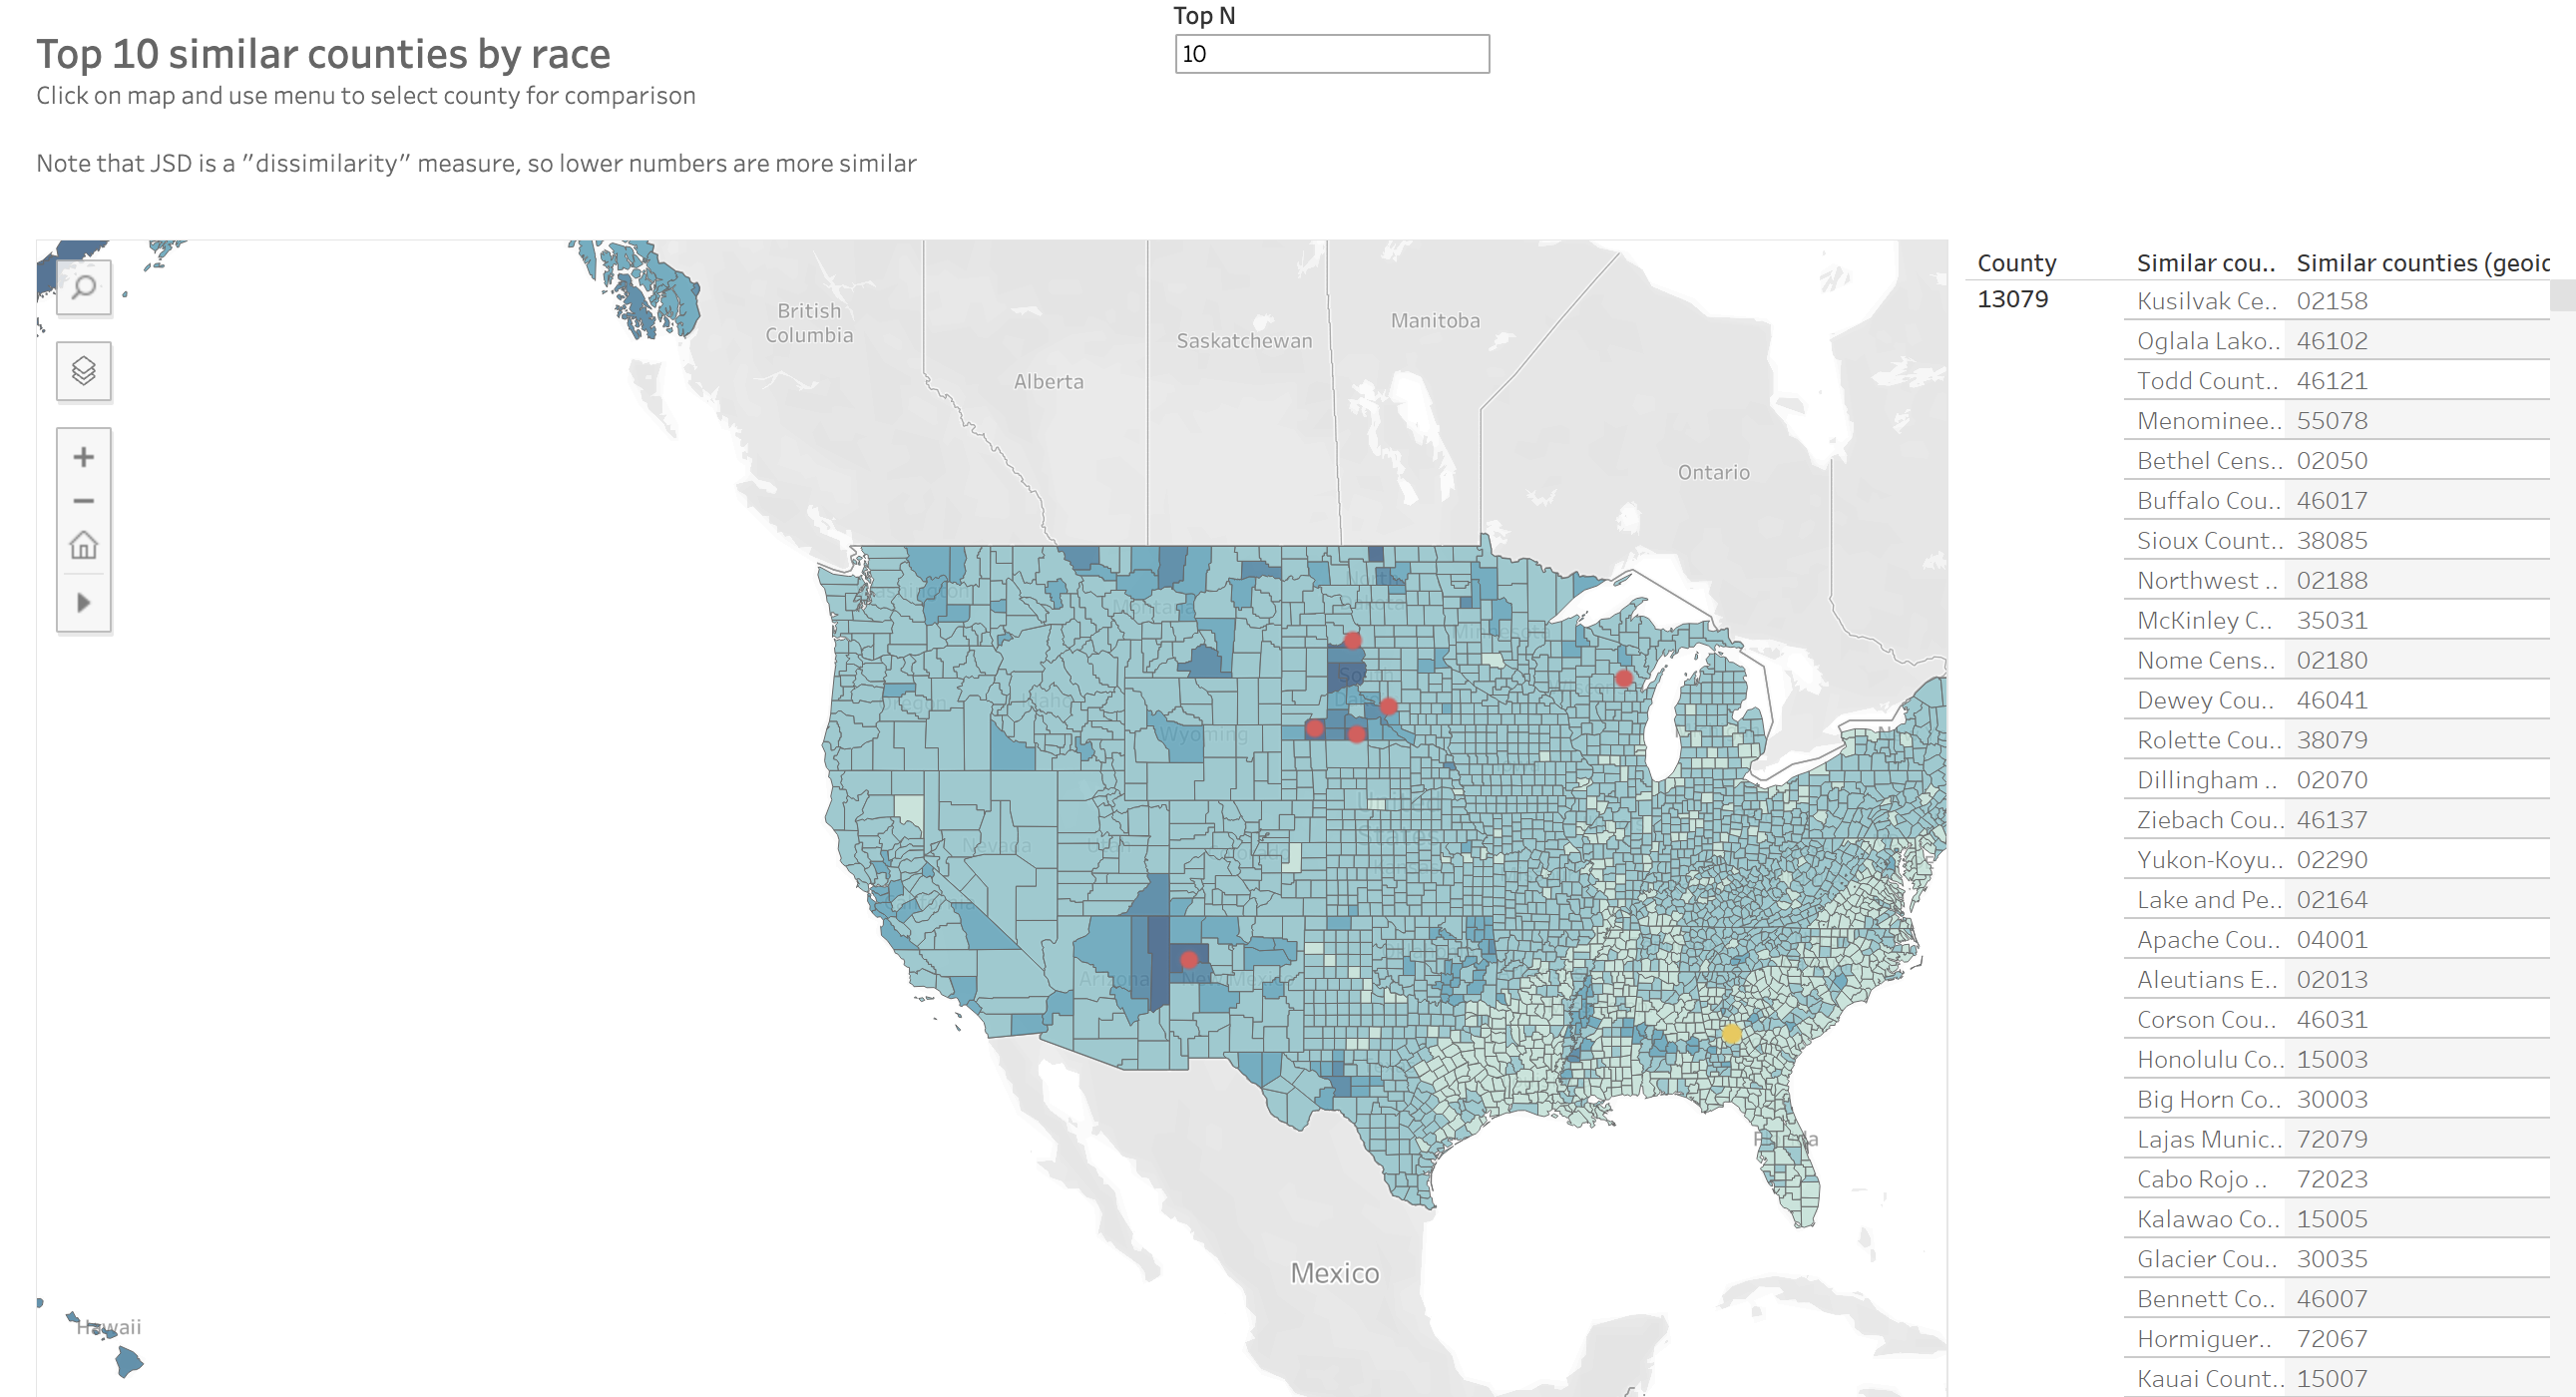

In [7]:
import pandas as pd
import datetime
import getpass
import snowflake.connector
from matplotlib.image import NonUniformImage
import matplotlib.pyplot as plt
from typing import List, Tuple, Union, Mapping, Any
from plotly.offline import init_notebook_mode
import string
import re
import numpy as np
import seaborn as sns
from numpy import ravel
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (20,10)
from sklearn.model_selection import *
import warnings
warnings.filterwarnings('ignore')
from scipy.spatial import distance
from time import time
import calendar
import time
import csv

In [ ]:
"""Snowflake Connection for REDH Public Instance"""

SNOWFLAKE_ACCOUNT = "racial_equity_data_hub"
DATABASE = "DATAHUB"
WAREHOUSE = "DE_COMPUTE_M_WH"

con = snowflake.connector.connect(
  user=getpass.getuser(),
  password=getpass.getpass(),
  account=SNOWFLAKE_ACCOUNT,
  warehouse=WAREHOUSE,
  database=DATABASE,
  schema="RAW")

In [4]:
counties_sql = """

SELECT *
FROM   "DATAHUB"."CURATIONS"."TABLEAU_ACS_DP05_US_COUNTIES_FUTURE"
WHERE  LABEL_CATEGORY = 'RACE'
       AND STATE = 'California'
       AND YEAR = '2011'
       AND DATASET = 'ACS1'
       AND LABEL_VALUE IN (
               'Asian', 'White', 'American Indian and Alaska Native','Black or African American',
               'Native Hawaiian and Other Pacific Islander', 'Some other race') 
ORDER BY STATE, COUNTY, LABEL_VALUE
"""

race_census_county_data = pd.read_sql(counties_sql, con)

In [16]:
tracts_sql = """

SELECT *
FROM   "DATAHUB"."CURATIONS"."TABLEAU_ACS_DP05_US_TRACT_FUTURE"
WHERE  LABEL_CATEGORY = 'RACE'
       AND STATE = 'Delaware'
       AND YEAR = '2011'
       AND DATASET = 'ACS5'
       AND LABEL_VALUE IN (
               'Asian', 'White', 'American Indian and Alaska Native','Black or African American',
               'Native Hawaiian and Other Pacific Islander', 'Some other race') 
ORDER BY STATE, COUNTY, LABEL_VALUE

"""

race_census_tract_data = pd.read_sql(tracts_sql, con)

#### Data Loading from Flat Files ####
- Users who don't have access to REDH public instance can download the data from [AWS Data Exchange](https://aws.amazon.com/marketplace/pp/prodview-hnl34ytkvhtug?ref_=unifiedsearch)
- Download the data as a flat file and read them into dataframes as mentioned below to perform region similarity exercise. The example data files mentioned in this notebook will be present in the repository to reproduce the analysis.

In [15]:
race_census_county_data = pd.read_csv(filepath_or_buffer = "~/Desktop/repos/rel-tableau-data-hub/acs_data/counties_data.csv")
race_census_tract_data = pd.read_csv(filepath_or_buffer = "~/Desktop/repos/rel-tableau-data-hub/acs_data/tracts_data.csv")

In [16]:
race_census_county_data.head(6)

,LOAD_DATE,YEAR,DATASET,SUBJECT,VARIABLE_BASE,GEO_ID,VALUE_E,VALUE_PE,STATE,COUNTY,LABEL_CATEGORY,LABEL_VALUE,LABEL_CONCEPT
0,2021-08-24 05:39:15.350,2011,ACS1,DP05,DP05_0061,0500000US06001,21230,NaN,California,Alameda County,RACE,American Indian and Alaska Native,RACE
1,2021-08-24 05:39:18.440,2011,ACS1,DP05,DP05_0062,0500000US06001,448250,NaN,California,Alameda County,RACE,Asian,RACE
2,2021-08-24 05:39:13.623,2011,ACS1,DP05,DP05_0060,0500000US06001,210706,NaN,California,Alameda County,RACE,Black or African American,RACE
3,2021-08-24 05:39:20.969,2011,ACS1,DP05,DP05_0063,0500000US06001,22617,NaN,California,Alameda County,RACE,Native Hawaiian and Other Pacific Islander,RACE
4,2021-08-24 05:39:22.858,2011,ACS1,DP05,DP05_0064,0500000US06001,140893,NaN,California,Alameda County,RACE,Some other race,RACE
5,2021-08-24 05:39:10.656,2011,ACS1,DP05,DP05_0059,0500000US06001,778051,NaN,California,Alameda County,RACE,White,RACE


In [17]:
race_tracts_census_data.head(6)

,LOAD_DATE,YEAR,DATASET,SUBJECT,VARIABLE_BASE,GEO_ID,VALUE_E,VALUE_PE,STATE,COUNTY,TRACT,LABEL_CATEGORY,LABEL_VALUE,LABEL_CONCEPT
0,2021-08-24 07:20:26.769,2011,ACS5,DP05,DP05_0061,1400000US10001041400,0,0,Delaware,Kent County,Census Tract 414,RACE,American Indian and Alaska Native,RACE
1,2021-08-24 07:20:26.769,2011,ACS5,DP05,DP05_0061,1400000US10001041300,6,0,Delaware,Kent County,Census Tract 413,RACE,American Indian and Alaska Native,RACE
2,2021-08-24 07:20:26.769,2011,ACS5,DP05,DP05_0061,1400000US10001040201,27,1,Delaware,Kent County,Census Tract 402.01,RACE,American Indian and Alaska Native,RACE
3,2021-08-24 07:20:26.769,2011,ACS5,DP05,DP05_0061,1400000US10001042800,332,5,Delaware,Kent County,Census Tract 428,RACE,American Indian and Alaska Native,RACE
4,2021-08-24 07:20:26.769,2011,ACS5,DP05,DP05_0061,1400000US10001040900,4,0,Delaware,Kent County,Census Tract 409,RACE,American Indian and Alaska Native,RACE
5,2021-08-24 07:20:26.769,2011,ACS5,DP05,DP05_0061,1400000US10001043202,2,0,Delaware,Kent County,Census Tract 432.02,RACE,American Indian and Alaska Native,RACE


In [18]:
race_census_county_data_pivoted = race_census_county_data.pivot(index = ['GEO_ID', 'COUNTY'], columns='LABEL_VALUE', values='VALUE_E').reset_index()
race_census_tract_data_pivoted = race_tracts_census_data.pivot(index = ['GEO_ID', 'COUNTY', 'TRACT'], columns='LABEL_VALUE', values='VALUE_E').reset_index()

In [19]:
race_census_county_data_pivoted.head()

LABEL_VALUE,GEO_ID,COUNTY,American Indian and Alaska Native,Asian,Black or African American,Native Hawaiian and Other Pacific Islander,Some other race,White
0,0500000US06001,Alameda County,21230,448250,210706,22617,140893,778051
1,0500000US06007,Butte County,11059,12469,6037,1107,8513,196992
2,0500000US06013,Contra Costa County,16137,184544,110389,12403,77192,728300
3,0500000US06017,El Dorado County,5486,9407,2311,0,7051,162726
4,0500000US06019,Fresno County,20505,102951,56774,4772,248851,548895


In [20]:
race_census_tract_data_pivoted.head()

LABEL_VALUE,GEO_ID,COUNTY,TRACT,American Indian and Alaska Native,Asian,Black or African American,Native Hawaiian and Other Pacific Islander,Some other race,White
0,1400000US10001040100,Kent County,Census Tract 401,15,65,440,0,120,6281
1,1400000US10001040201,Kent County,Census Tract 402.01,27,37,1282,18,43,4045
2,1400000US10001040202,Kent County,Census Tract 402.02,268,205,2914,0,130,8676
3,1400000US10001040203,Kent County,Census Tract 402.03,63,91,1755,0,80,2913
4,1400000US10001040501,Kent County,Census Tract 405.01,69,71,2804,0,101,2458


In [21]:
def similarity_calculation(dataset, geoId1, geoId2, aggregate_level):
    if (aggregate_level == 'County'):
        matrix1_features = dataset.loc[(dataset['GEO_ID'] == geoId1)].iloc[:,3:].values
        matrix2_features = dataset.loc[(dataset['GEO_ID'] == geoId2)].iloc[:,3:].values
        from sklearn.preprocessing import Normalizer
        normalizer = Normalizer()
        matrix1_scaled = normalizer.fit_transform(matrix1_features)
        matrix2_scaled = normalizer.fit_transform(matrix2_features)
        return distance.jensenshannon(matrix1_scaled , matrix2_scaled, axis = 1)[0]
    else:
        matrix1_features = dataset.loc[(dataset['GEO_ID'] == geoId1)].iloc[:,4:].values
        matrix2_features = dataset.loc[(dataset['GEO_ID'] == geoId2)].iloc[:,4:].values
        from sklearn.preprocessing import Normalizer
        normalizer = Normalizer()
        matrix1_scaled = normalizer.fit_transform(matrix1_features)
        matrix2_scaled = normalizer.fit_transform(matrix2_features)
        return distance.jensenshannon(matrix1_scaled , matrix2_scaled, axis = 1)[0]

In [22]:
def similar_counties(dataset, aggregate_level):
    results = []
    for geoId1 in dataset["GEO_ID"].unique():
        for geoId2 in dataset["GEO_ID"].unique():
            #print(geoId2)
            if geoId1 != geoId2:
                if aggregate_level == 'County':
                #print(geoId1, geoId2)
                    results.append({
                        "county_base_geoId": geoId1,
                        "county_similar_geoId": geoId2,
                        "score": similarity_calculation(dataset, geoId1, geoId2, aggregate_level),
                        "countyname_base": dataset.loc[(dataset['GEO_ID'] == geoId1)].iloc[:,1].values[0],
                        "countyname_similar": dataset.loc[(dataset['GEO_ID'] == geoId2)].iloc[:,1].values[0]
                    })
                elif aggregate_level == 'Tract':
                    results.append({
                    "tract_base_geoId": geoId1,
                    "tract_similar_geoId": geoId2,
                    "score": similarity_calculation(dataset, geoId1, geoId2, aggregate_level),
                    "countyname_base": dataset.loc[(dataset['GEO_ID'] == geoId1)].iloc[:,1].values[0],
                    "countyname_similar": dataset.loc[(dataset['GEO_ID'] == geoId2)].iloc[:,1].values[0],
                    "tractname_base": dataset.loc[(dataset['GEO_ID'] == geoId1)].iloc[:,2].values[0],
                    "tractname_similar": dataset.loc[(dataset['GEO_ID'] == geoId2)].iloc[:,2].values[0]
                })
            else:
                continue
    return results

In [26]:
%%time
results = similar_counties(dataset = race_census_county_data_pivoted, 
                           aggregate_level = 'County')
results_dataframe = pd.DataFrame(results, columns=["county_base_geoId", "county_similar_geoId", "score", "countyname_base", "countyname_similar" ])
results_dataframe.to_csv("~/Desktop/repos/rel-tableau-data-hub/acs_data/similar_regions_counties.csv", sep=",")

CPU times: user 2.32 s, sys: 10.6 ms, total: 2.33 s
Wall time: 2.32 s


In [24]:
results_dataframe.head()

,county_base_geoId,county_similar_geoId,score,countyname_base,countyname_similar
0,0500000US06001,0500000US06007,0.307395,Alameda County,Butte County
1,0500000US06001,0500000US06013,0.124174,Alameda County,Contra Costa County
2,0500000US06001,0500000US06017,0.335181,Alameda County,El Dorado County
3,0500000US06001,0500000US06019,0.227836,Alameda County,Fresno County
4,0500000US06001,0500000US06023,0.336442,Alameda County,Humboldt County


In [27]:
%%time
results = similar_counties(dataset = race_census_tract_data_pivoted, 
                           aggregate_level = 'Tract')
results_dataframe = pd.DataFrame(results, columns=["tract_base_geoId", "tract_similar_geoId", "score", "countyname_base", "countyname_similar","tractname_base", "tractname_similar"])
results_dataframe.to_csv("~/Desktop/repos/rel-tableau-data-hub/acs_data/similar_regions_tracts.csv", sep=",")

CPU times: user 1min 37s, sys: 169 ms, total: 1min 37s
Wall time: 1min 37s


In [39]:
results_dataframe.head()

,tract_base_geoId,tract_similar_geoId,score,countyname_base,countyname_similar,tractname_base,tractname_similar
0,1400000US10001040100,1400000US10001040201,0.180654,Kent County,Kent County,Census Tract 401,Census Tract 402.01
1,1400000US10001040100,1400000US10001040202,0.185135,Kent County,Kent County,Census Tract 401,Census Tract 402.02
2,1400000US10001040100,1400000US10001040203,0.272805,Kent County,Kent County,Census Tract 401,Census Tract 402.03
3,1400000US10001040100,1400000US10001040501,0.373920,Kent County,Kent County,Census Tract 401,Census Tract 405.01
4,1400000US10001040100,1400000US10001040502,0.187315,Kent County,Kent County,Census Tract 401,Census Tract 405.02
